In [263]:
import pandas as pd
import nltk
import pickle
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
import ssl
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

Populating the interactive namespace from numpy and matplotlib


In [74]:
pd.options.display.max_rows = 200

In [5]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


KeyboardInterrupt: 

In [6]:
for dl in ["averaged_perceptron_tagger", "maxent_treebank_pos_tagger", "punkt", "maxent_ne_chunker", "words"]:
    nltk.download(dl)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
conventions = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/convention_speeches.pkl")

In [11]:
example = conventions["Speech"].iloc[35]

In [51]:
def polarity_column(speech):
    return TextBlob(speech).sentiment.polarity

def subjectivity_column(speech):
    return TextBlob(speech).sentiment.subjectivity

conventions["Polarity"] = conventions.apply(lambda row: polarity_column(row["Speech"]),axis=1)
conventions["Subjectivity"] = conventions.apply(lambda row: subjectivity_column(row["Speech"]),axis=1)

In [51]:
conventions.sort_values(by="Polarity", ascending=False)

0     0.169430
1     0.149223
2     0.148300
3     0.170496
4     0.164313
5     0.164060
6     0.109578
7     0.227608
8     0.116004
9     0.147830
10    0.122605
11    0.161397
12    0.132374
13    0.224530
14    0.111130
15    0.162932
16    0.207976
17    0.091104
18    0.142659
19    0.131219
20    0.188553
21    0.090750
22    0.123650
23    0.125737
24    0.096626
25    0.192359
26    0.149597
27    0.197922
28    0.145167
29    0.155669
30    0.150481
31    0.157193
32    0.109210
33    0.115955
34    0.185736
35    0.175929
36    0.193669
37    0.201830
38    0.222832
39    0.162605
40    0.220335
41    0.190437
42    0.159328
43    0.101273
44    0.123333
45    0.112448
46    0.152108
47    0.152144
48    0.129113
49    0.116661
50    0.178712
51    0.152320
52    0.109489
53    0.208297
54    0.136111
Name: Polarity, dtype: float64

In [78]:
nominees = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/nominees.pkl")
nominees
year_sums = nominees.groupby("Year", as_index=False).agg({"Electoral Votes": sum})
year_sums["Majority"] = year_sums.apply(lambda row: row["Electoral Votes"]/2, axis=1)
year_sums = year_sums[["Year", "Majority"]]
nominees = nominees.merge(year_sums, on="Year")
nominees

,Name,Year,Party,Electoral Votes,Result,Majority
0,Hillary Clinton,2016,Democratic,227,Lost,265.5
1,Donald Trump,2016,Republican,304,Won,265.5
2,Barack Obama,2012,Democratic,332,Won,269.0
3,Mitt Romney,2012,Republican,206,Lost,269.0
4,Barack Obama,2008,Democratic,365,Won,269.0
5,John McCain,2008,Republican,173,Lost,269.0
6,John F. Kerry,2004,Democratic,251,Lost,268.5
7,George W. Bush,2004,Republican,286,Won,268.5
8,"Albert Gore, Jr.",2000,Democratic,266,Lost,268.5
9,George W. Bush,2000,Republican,271,Won,268.5


In [14]:
def win_or_lose(votes, majority):
    if votes>=majority:
        return "Won"
    else:
        return "Lost"

In [79]:
nominees["Result"] = nominees.apply(lambda row: win_or_lose(row["Electoral Votes"], row["Majority"]), axis=1)
nominees.drop("Majority", axis=1, inplace=True)

In [81]:
nominees[nominees.Name == "Herbert Hoover"]

,Name,Year,Party,Electoral Votes,Result
46,Herbert Hoover,1932,Republican,59,Lost
48,Herbert Hoover,1928,Republican,444,Won


In [19]:
with open("/Users/danielgilberg/data_science/metis/presidential_speeches/data/nominees.pkl", "wb") as picklefile:
    pickle.dump(nominees, picklefile)

In [52]:
platforms = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/platforms.pkl")
platforms["Polarity"] = platforms.apply(lambda row: polarity_column(row["Platform"]), axis=1)
platforms["Subjectivity"] = platforms.apply(lambda row: subjectivity_column(row["Platform"]), axis=1)

In [100]:
party_years = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/party_years.pkl")

In [128]:
temp_speech = party_years.iloc[0]["Speech"]
sentences = nltk.tokenize.sent_tokenize(temp_speech)
tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(sentences[10])

['What', 'a', 'remarkable', 'week', 'it', "'s", 'been', '!']

In [127]:
nltk.word_tokenize(sentences[10])


['What', 'a', 'remarkable', 'week', 'it', "'s", 'been', '!']

In [118]:
nltk.wordpunct_tokenize(sentences[10])


['What', 'a', 'remarkable', 'week', 'it', "'", 's', 'been', '!']

In [124]:
nltk.tag.pos_tag(nltk.word_tokenize(sentences[10]))

[('What', 'WP'),
 ('a', 'DT'),
 ('remarkable', 'JJ'),
 ('week', 'NN'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('been', 'VBN'),
 ('!', '.')]

In [160]:
arr = textwrap.wrap(temp_speech, len(temp_speech)//20)
temp = list()
for index, x in enumerate(arr):
    if index != len(arr)-1:
        temp.append(TextBlob(x).sentiment.polarity)
        
np.min(temp), np.max(temp)

(-0.036805555555555564, 0.38092105263157888)

Graph sentimentality of a speech as it progresses

In [256]:
len(conventions[conventions.Year>1915])
temp_speech = conventions.iloc[0]["Speech"]
word_vect = nltk.word_tokenize(temp_speech)
sent_vect = nltk.sent_tokenize(temp_speech)
vect = CountVectorizer(ngram_range=(1,2))

temp_platform = platforms.iloc[0]["Platform"]
sent_plat = nltk.sent_tokenize(temp_platform)
vect.fit(sent_plat)
data = vect.transform(sent_vect)
x = pd.DataFrame(data.toarray(), columns=vect.get_feature_names())
x.columns

Index(['000', '000 americans', '10', '10 20', '10 percent', '10 times',
       '10 year', '100', '100 days', '100 percent',
       ...
       'zealand the', 'zero', 'zero suicide', 'zika', 'zika just',
       'zika pandemic', 'zip', 'zip code', 'zones', 'zones and'],
      dtype='object', length=19473)

In [223]:
df = pd.DataFrame(pairwise_distances(data, metric='cosine'))


In [226]:
for col in df.columns:
    print(df[col].mean())

0.874077331325
0.894349709974
0.862866935554
0.866145426545
0.864533821436
0.915794958452
0.887292230208
0.893783303314
0.823832438031
0.862703605232
0.965949491445
0.870756436032
0.946452157671
0.90470905842
0.870351762996
0.916151947004
0.911086697087
0.844371431026
0.817414252574
0.903108059797
0.890291311925
0.892716627472
0.900894670332
0.810379444044
0.963601930181
0.920247888358
0.887842992674
0.901111082175
0.862555083806
0.863535091366
0.853180068356
0.865426977576
0.886260056582
0.893760147618
0.971014032044
0.890349827974
0.949402017349
0.941061932206
0.910055356008
0.906942235048
0.908703336636
0.893705826421
0.911713248695
0.893369331105
0.951442776788
0.840569646329
0.885669077383
0.896094340926
0.871249772678
0.875486396173
0.922465564175
0.928728019437
0.859708993218
0.930170271298
0.849547410649
0.937678965601
0.844097405482
0.901443329234
0.939395046826
0.977632195523
0.930614930615
0.885277367255
0.835160649918
0.862138701442
0.844314111661
0.892644424077
0.970293777

In [300]:
mask = (conventions.Party == "Republican") & (conventions.Year == 2016)
trump_speech = conventions[mask]["Speech"][24]


### Visuals

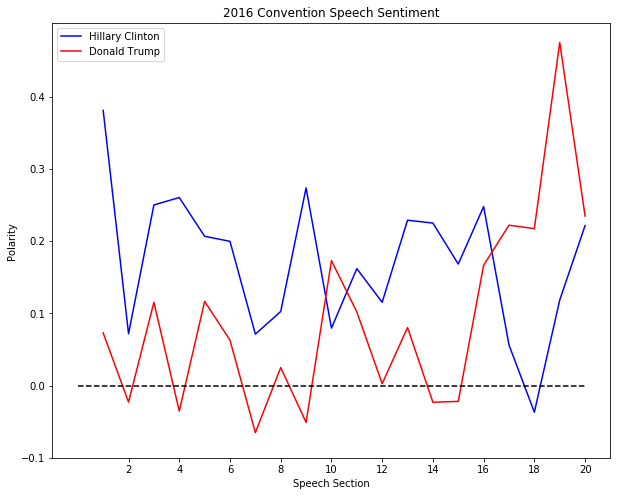

In [310]:
x = range(1,21)
speech_parts = textwrap.wrap(temp_speech, len(temp_speech)//20)[:-1]
dem_y = list()
for a in speech_parts:
    dem_y.append(TextBlob(a).sentiment.polarity)
    

gop_y = list()
trump_parts = textwrap.wrap(trump_speech, len(trump_speech)//20)[:-1]
for a in trump_parts:
    gop_y.append(TextBlob(a).sentiment.polarity)
zeros = np.zeros(21)
plt.figure(figsize=(10,8))
plt.plot(x, dem_y, color="blue", label="Hillary Clinton")
plt.plot(x, gop_y, color="red", label="Donald Trump")
plt.plot(range(0,21), zeros,"--", color="black")
plt.xticks(range(2,21,2))
plt.yticks(np.arange(-0.1, 0.5, 0.1))
plt.xlabel("Speech Section")
plt.ylabel("Polarity")
plt.title("2016 Convention Speech Sentiment")
plt.legend()